In [8]:
import matplotlib.pyplot as plt
import numpy as np

import regions
import photutils
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.wcs import WCS
from astropy.nddata import CCDData
from astropy import stats
from astropy.convolution import Gaussian2DKernel

from skycam_utils.photometry import make_background, make_segmentation_image
from skycam_utils.astrometry import solve_field

In [2]:
hdul = fits.open("../2020/image_0007410.fits")
im = hdul[0].data
hdr = hdul[0].header

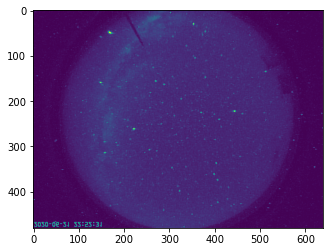

In [3]:
plt.imshow(im)

In [4]:
fov = regions.read_ds9("fov.reg")[0].to_mask(mode='exact')
mmt = regions.read_ds9("mmt.reg")[0].to_mask(mode='subpixels')
pole = regions.read_ds9("pole.reg")[0].to_mask(mode='subpixels')
center = regions.read_ds9("small.reg")[0].to_mask(mode='subpixels')

sh = im.shape
mask_image = fov.to_image(sh) - mmt.to_image(sh) - pole.to_image(sh)
mask_image[mask_image <= 0] = np.nan

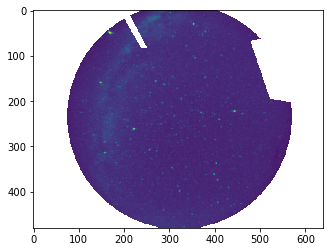

In [5]:
plt.imshow(mask_image * im)

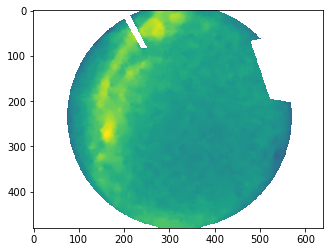

In [7]:
masked_im = np.ma.masked_where(mask_image == np.nan, im)
bkg = make_background(im, boxsize=(5, 5), filter_size=(3, 3), inmask=mask_image)
plt.imshow(bkg.background * mask_image)
#plt.imshow(mask_image)

In [7]:
outmask = CCDData(mask_image, unit=u.adu)
outmask.write("mask_2017_2020.fits")

In [51]:
subt = CCDData(im - bkg.background * mask_image, unit=u.adu)
subt.write("../2020/masked_subt.fits", overwrite=True)

In [52]:
# solved_fp = solve_field("masked_subt.fits", x_size=300, y_size=300)

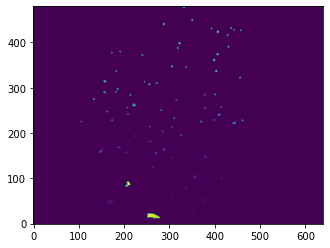

In [53]:
segm = make_segmentation_image(subt.data)
plt.imshow(segm, origin='lower')

In [54]:
fwhm = 2.0
sigma = fwhm * stats.gaussian_fwhm_to_sigma
kernel = Gaussian2DKernel(sigma, x_size=5, y_size=5)
cat = photutils.source_properties(im, segm, background=bkg.background)
t = cat.to_table()
t['obs_mag'] = -2.5 * np.log10(t['source_sum'])
t.sort('obs_mag')

In [55]:
t

id,xcentroid,ycentroid,sky_centroid,sky_centroid_icrs,source_sum,source_sum_err,background_sum,background_mean,background_at_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,min_value,max_value,minval_xpos,minval_ypos,maxval_xpos,maxval_ypos,area,equivalent_radius,perimeter,semimajor_axis_sigma,semiminor_axis_sigma,orientation,eccentricity,ellipticity,elongation,covar_sigx2,covar_sigxy,covar_sigy2,cxx,cxy,cyy,gini,obs_mag
,pix,pix,,,,,,,,pix,pix,pix,pix,,,pix,pix,pix,pix,pix2,pix,pix,pix,pix,deg,,,,pix2,pix2,pix2,1 / pix2,1 / pix2,1 / pix2,,
int64,float64,float64,object,object,uint64,object,float64,float64,float64,float64,float64,float64,float64,uint8,uint8,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
5,169.7466110531804,49.08711726229974,None,None,10549,None,2106.245748446179,23.934610777797488,25.212128637516344,164.0,177.0,44.0,53.0,20,255,171.0,46.0,168.0,49.0,88.0,5.292567428401227,35.798989873223334,3.082065708537417,1.5492765069753578,22.31090858987518,0.8644756382702038,0.4973252832722501,1.9893580614312116,8.476034822746346,2.4932092560552865,3.423351904061668,0.15014465873284832,-0.21869913663030563,0.3717500834077453,0.3668191025351861,-10.058028230822222
78,266.92193349482494,16.927769213829553,None,None,9082,None,5137.062720815623,43.90651898133011,44.45157446353564,260.0,275.0,12.0,22.0,60,97,260.0,15.0,271.0,18.0,117.0,6.102643417692329,44.627416997969526,4.204638266129466,2.2661916923137255,-16.831028650448687,0.84232225078436,0.4610257651486762,1.8553762598240904,16.627356402535884,-3.4763501021135044,6.187251332776061,0.06814707105393641,0.07657780965260895,0.18313554392081596,0.06362528381261913,-9.89545374391237
43,222.3164812942366,261.44934277047525,None,None,4945,None,1278.7438801344747,31.968597003361868,31.892955531898764,219.0,226.0,259.0,265.0,35,255,219.0,260.0,224.0,261.0,40.0,3.5682482323055424,21.899494936611667,1.7059846928963072,1.3216268572683403,-14.197155756213398,0.6323285867730787,0.22529969772204095,1.2908217501136388,2.840385596465059,-0.2766878535477717,1.8166957257844376,0.35736681631512607,0.10885593655782692,0.5587394428848356,0.34491716574628606,-9.235415739832995
80,256.02086776859505,18.76694214876033,None,None,4840,None,2739.7673545551165,39.13953363650167,39.598298070963494,252.0,261.0,14.0,23.0,51,86,252.0,15.0,258.0,21.0,70.0,4.720348719413148,34.31370849898476,2.8040909531038203,2.174582742559249,53.44313446655642,0.6313430949151664,0.22449635945216928,1.289484597768723,5.840680238713203,1.4994914964824806,6.751055938801995,0.18156646565431178,-0.0806562332657348,0.15708234053654185,0.054527488321954726,-9.212113404111031
29,443.95375849222,222.05610344071883,None,None,4563,None,1054.507397097093,27.750194660449814,27.707948645675124,438.0,448.0,220.0,224.0,37,254,442.0,220.0,444.0,221.0,38.0,3.477898169151024,21.692388155425117,2.0232930648975582,1.0210645555615476,1.0160439836035757,0.8633212226964819,0.49534520071453647,1.9815525412933583,4.092755433236562,0.05409551303784183,1.0435322198500945,0.24450169575017275,-0.025349374784283923,0.9589408210709803,0.3756833756833757,-9.148126171931652
19,148.94000517196793,158.94931471424877,None,None,3867,None,1283.6091635003718,40.11278635938662,40.23319649783176,145.0,153.0,157.0,161.0,46,255,146.0,157.0,148.0,159.0,32.0,3.1915382432114616,19.899494936611664,1.8542264724257689,0.9882681828251033,10.652768366563452,0.8461269699694435,0.46701862069080824,1.8762381554419796,3.3540422032315904,0.44717895363478544,1.0607876089973518,0.31590264108575056,-0.2663398616141713,0.9988340562494017,0.30728997222152704,-8.968435430182664
3,353.88248716486027,30.187963491158015,None,None,3506,None,999.3109432699193,32.235836879674814,32.13761948252899,352.0,356.0,27.0,34.0,30,255,352.0,28.0,354.0,29.0,31.0,3.141274657157109,18.485281374238568,1.5937369985176333,1.0404655143668173,-89.74704133342091,0.7574902871512851,0.3471

In [56]:
t.keep_columns(['id', 'xcentroid', 'ycentroid', 'source_sum', 'background_mean', 'obs_mag'])
t.write("../2020/sources.csv")

In [23]:
wcs = WCS("masked_subt.wcs")

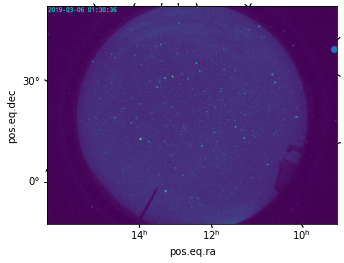

In [55]:
ax = plt.subplot(projection=wcs)
#plt.grid(color='white', ls='solid')
ax.imshow(im)
co_x, co_y = 116.3 * u.deg, 28.0 * u.deg
ax.scatter(co_x, co_y, transform=ax.get_transform('world'))
plt.show()

In [54]:
wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'  
CRVAL : 183.250957378  25.6532371745  
CRPIX : 313.896687826  211.121007284  
CD1_1 CD1_2  : -0.271203202065  -0.0358738590292  
CD2_1 CD2_2  : -0.0348827990897  0.2743735958  
NAXIS : 0  0

In [17]:
np.zeros_like(im, dtype=bool)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])